# Detecting Frauds in Financial Transaction

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import codecs
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [31]:
data = pd.read_csv("dataset.csv")
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [32]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
305715,15,PAYMENT,2971.13,C1466783405,116846.0,113874.87,M965399827,0.00,0.00,0,0
305716,15,CASH_OUT,103103.69,C1551854474,78.0,0.00,C1674595815,0.00,103103.69,0,0
305717,15,CASH_OUT,576077.32,C1891797648,146468.0,0.00,C1244839062,783985.25,1360062.57,0,0
305718,15,CASH_OUT,206863.12,C1302819355,84795.0,0.00,C741622963,806218.97,1013082.09,0,0


In [33]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,305720.000000,3.057200e+05,3.057200e+05,3.057200e+05,3.057200e+05,3.057200e+05,305720.000000,305720.0
mean,11.508050,1.759039e+05,8.921656e+05,9.108689e+05,9.767185e+05,1.193642e+06,0.000612,0.0
std,2.659029,3.003670e+05,2.880219e+06,2.917519e+06,2.367940e+06,2.589435e+06,0.024724,0.0
min,1.000000,3.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,10.000000,1.275471e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,12.000000,7.788798e+04,1.884583e+04,0.000000e+00,8.607539e+04,1.912892e+05,0.000000,0.0
75%,14.000000,2.314969e+05,1.848412e+05,2.225742e+05,8.575243e+05,1.234561e+06,0.000000,0.0
max,15.000000,1.000000e+07,3.890000e+07,3.890000e+07,4.130000e+07,4.140000e+07,1.000000,0.0


# Data Cleaning

In [34]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

<Figure size 1000x600 with 0 Axes>

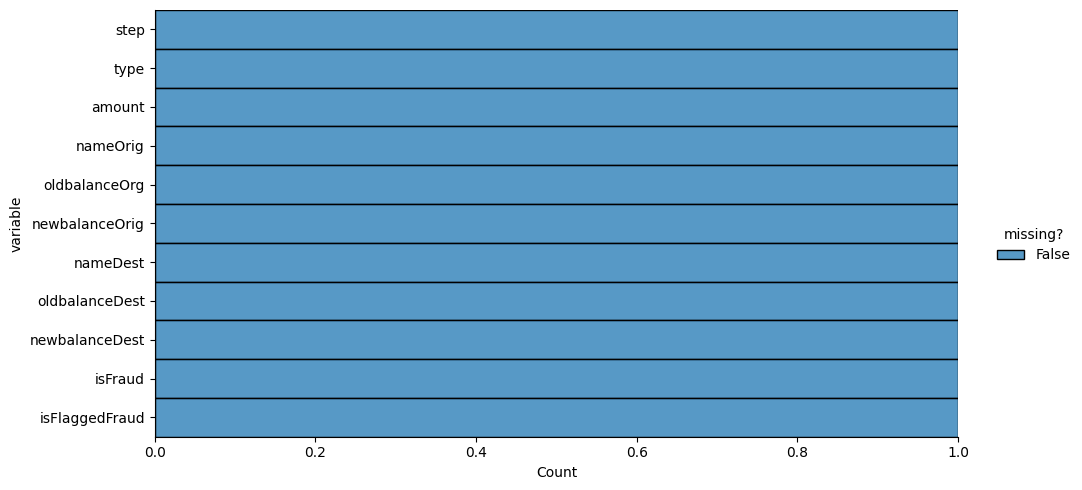

In [35]:
plt.figure(figsize=(10,6))
sns.displot(
    data=data.isna().melt(value_name="missing?"),
    y="variable",
    hue="missing?",
    multiple="fill",
    aspect=2
)

In [36]:
data.type.value_counts()

type
CASH_OUT    107363
PAYMENT     105938
CASH_IN      64716
TRANSFER     25441
DEBIT         2262
Name: count, dtype: int64

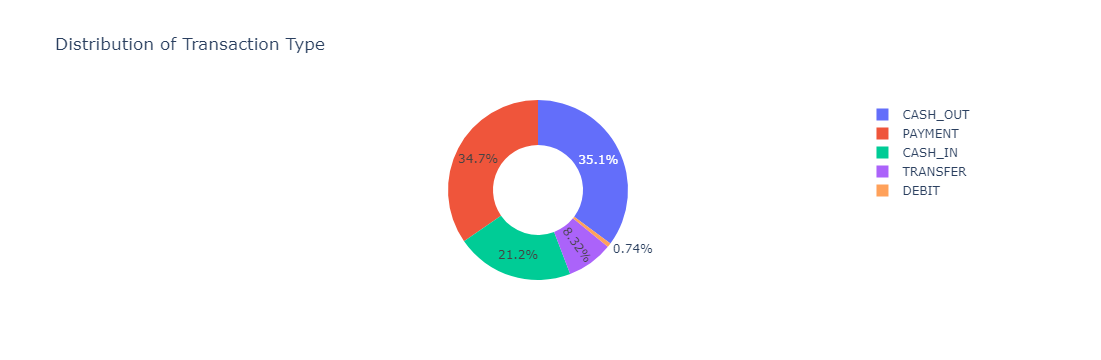

In [37]:
type = data["type"].value_counts()
transactions = type.index
quantity = type.values

import plotly.express as px
figure = px.pie(data, 
             values=quantity, 
             names=transactions,hole = 0.5, 
             title="Distribution of Transaction Type")
figure.show()

In [38]:
numeric_data = data.select_dtypes(include=['float64', 'int64'])

correlation = numeric_data.corr()
print(correlation["isFraud"].sort_values(ascending=False))


isFraud           1.000000
amount            0.045424
oldbalanceOrg    -0.001492
newbalanceDest   -0.004061
oldbalanceDest   -0.007318
newbalanceOrig   -0.007571
step             -0.027365
isFlaggedFraud         NaN
Name: isFraud, dtype: float64


# Random Forest

RF Balanced Accuracy Score:  0.7199836362446272


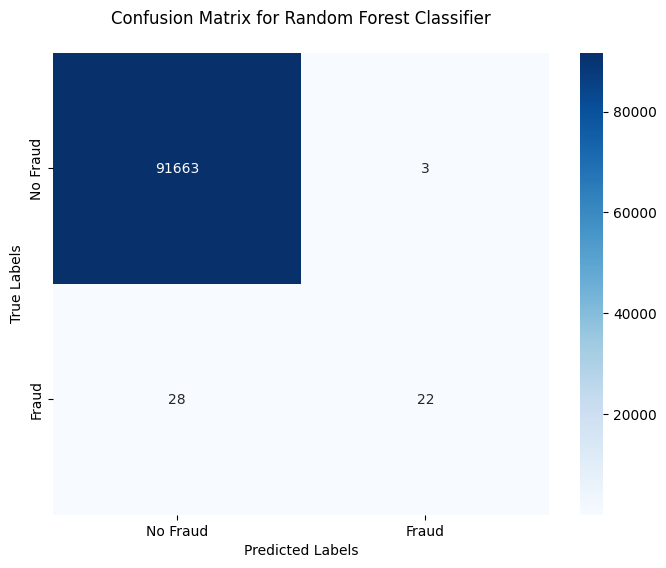

Classification Report (RF):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     91666
           1       0.88      0.44      0.59        50

    accuracy                           1.00     91716
   macro avg       0.94      0.72      0.79     91716
weighted avg       1.00      1.00      1.00     91716



In [39]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('dataset.csv')

label_encoder = LabelEncoder()
df['type_encoded'] = label_encoder.fit_transform(df['type'])

X = df[['step', 'type_encoded', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
        'oldbalanceDest', 'newbalanceDest']]
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

rf_classifier = RandomForestClassifier(n_estimators=500, random_state=1)

rf_classifier.fit(X_train, y_train)

rf_predictions = rf_classifier.predict(X_test)

rf_balanced_acc_score = balanced_accuracy_score(y_test, rf_predictions)
print("RF Balanced Accuracy Score: ", rf_balanced_acc_score)

rf_confusion_matrix = confusion_matrix(y_test, rf_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(rf_confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Fraud', 'Fraud'], 
            yticklabels=['No Fraud', 'Fraud'])
plt.title('Confusion Matrix for Random Forest Classifier\n')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

rf_classification_report = classification_report(y_test, rf_predictions)
print("Classification Report (RF):\n", rf_classification_report)

# XGBoost

XGBoost Balanced Accuracy Score:  0.7899672724892545


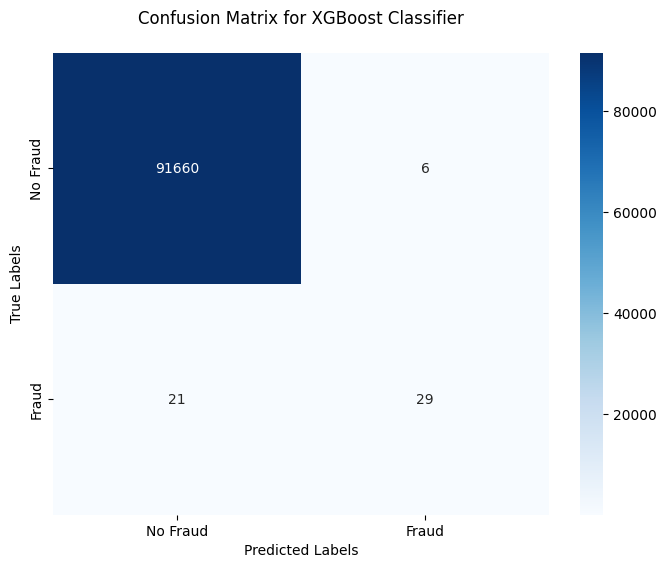

Classification Report (XGBoost):
               precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     91666
       Fraud       0.83      0.58      0.68        50

    accuracy                           1.00     91716
   macro avg       0.91      0.79      0.84     91716
weighted avg       1.00      1.00      1.00     91716



In [40]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('dataset.csv')

label_encoder = LabelEncoder()
df['type_encoded'] = label_encoder.fit_transform(df['type'])

X = df[['step', 'type_encoded', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
        'oldbalanceDest', 'newbalanceDest']]
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

xgb_classifier = XGBClassifier(random_state=1)

xgb_classifier.fit(X_train, y_train)

xgb_predictions = xgb_classifier.predict(X_test)

xgb_balanced_acc_score = balanced_accuracy_score(y_test, xgb_predictions)
print("XGBoost Balanced Accuracy Score: ", xgb_balanced_acc_score)

xgb_confusion_matrix = confusion_matrix(y_test, xgb_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(xgb_confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Fraud', 'Fraud'], 
            yticklabels=['No Fraud', 'Fraud'])
plt.title('Confusion Matrix for XGBoost Classifier\n')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

xgb_classification_report = classification_report(y_test, xgb_predictions, target_names=["No Fraud", "Fraud"])
print("Classification Report (XGBoost):\n", xgb_classification_report)

# KNN

KNN Balanced Accuracy Score:  0.529978181659503


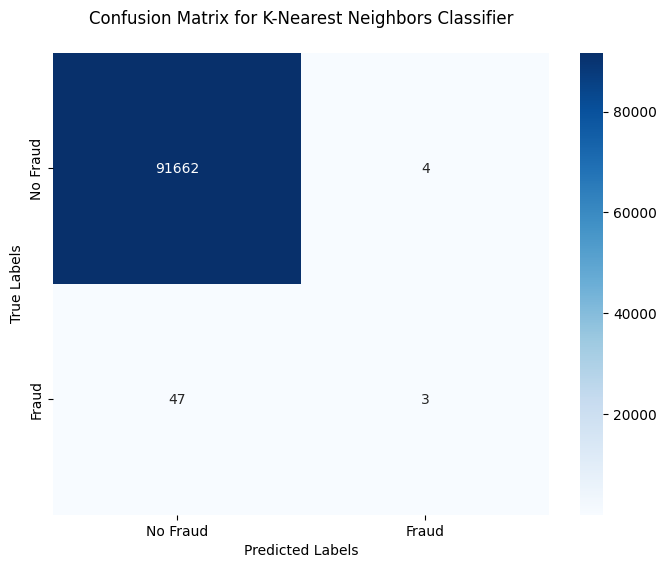

Classification Report (KNN):
               precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     91666
       Fraud       0.43      0.06      0.11        50

    accuracy                           1.00     91716
   macro avg       0.71      0.53      0.55     91716
weighted avg       1.00      1.00      1.00     91716



In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('dataset.csv')

label_encoder = LabelEncoder()
df['type_encoded'] = label_encoder.fit_transform(df['type'])

X = df[['step', 'type_encoded', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
        'oldbalanceDest', 'newbalanceDest']]
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

knn_classifier = KNeighborsClassifier(n_neighbors=5)

knn_classifier.fit(X_train, y_train)

knn_predictions = knn_classifier.predict(X_test)

knn_balanced_acc_score = balanced_accuracy_score(y_test, knn_predictions)
print("KNN Balanced Accuracy Score: ", knn_balanced_acc_score)

knn_confusion_matrix = confusion_matrix(y_test, knn_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(knn_confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Fraud', 'Fraud'], 
            yticklabels=['No Fraud', 'Fraud'])
plt.title('Confusion Matrix for K-Nearest Neighbors Classifier\n')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

knn_classification_report = classification_report(y_test, knn_predictions, target_names=["No Fraud", "Fraud"])
print("Classification Report (KNN):\n", knn_classification_report)

# Histogram Gradient Boosting Classifier

HIST Gradient Classifier Balanced Accuracy Score:  0.5992036305718587


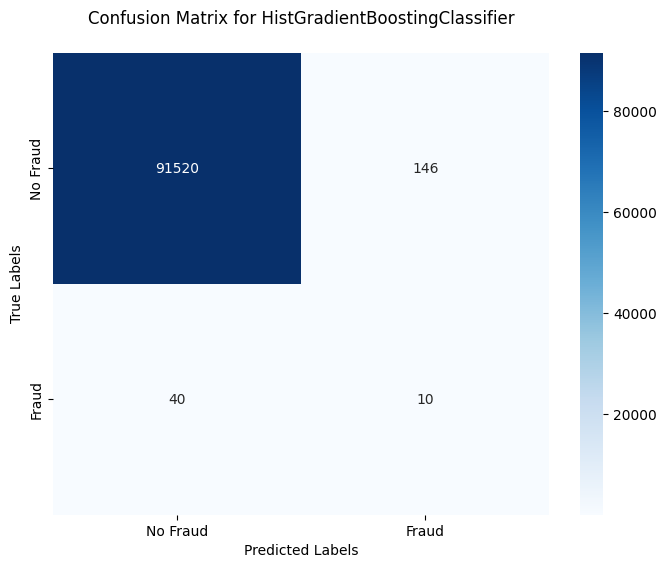

Classification Report (HIST):
               precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     91666
       Fraud       0.06      0.20      0.10        50

    accuracy                           1.00     91716
   macro avg       0.53      0.60      0.55     91716
weighted avg       1.00      1.00      1.00     91716



In [42]:
from sklearn.ensemble import HistGradientBoostingClassifier

df = pd.read_csv('dataset.csv')

label_encoder = LabelEncoder()
df['type_encoded'] = label_encoder.fit_transform(df['type'])

X = df[['step', 'type_encoded', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
        'oldbalanceDest', 'newbalanceDest']]
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

hgb_classifier = HistGradientBoostingClassifier(random_state=1)

hgb_classifier.fit(X_train, y_train)

hgb_predictions = hgb_classifier.predict(X_test)

hgb_balanced_acc_score = balanced_accuracy_score(y_test, hgb_predictions)
print("HIST Gradient Classifier Balanced Accuracy Score: ", hgb_balanced_acc_score)

hgb_confusion_matrix = confusion_matrix(y_test, hgb_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(hgb_confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Fraud', 'Fraud'], 
            yticklabels=['No Fraud', 'Fraud'])
plt.title('Confusion Matrix for HistGradientBoostingClassifier\n')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

hgb_classification_report = classification_report(y_test, hgb_predictions, target_names=["No Fraud", "Fraud"])
print("Classification Report (HIST):\n", hgb_classification_report)

# Decision Tree Classifier

Decision Tree Balanced Accuracy Score:  0.84192524810209


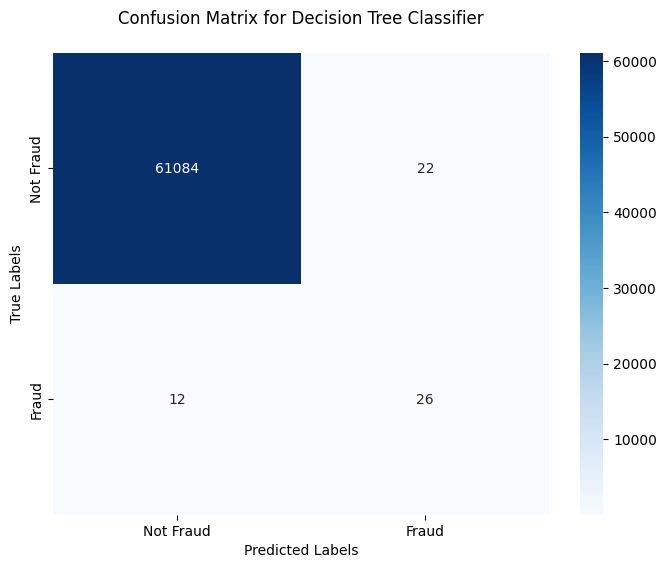

Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     61106
           1       0.54      0.68      0.60        38

    accuracy                           1.00     61144
   macro avg       0.77      0.84      0.80     61144
weighted avg       1.00      1.00      1.00     61144



In [43]:
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv('dataset.csv')

features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
X = data[features]
y = data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

dt_classifier = DecisionTreeClassifier(random_state=1)

dt_classifier.fit(X_train, y_train)

dt_predictions = dt_classifier.predict(X_test)

dt_balanced_acc_score = balanced_accuracy_score(y_test, dt_predictions)
print("Decision Tree Balanced Accuracy Score: ", dt_balanced_acc_score)

dt_confusion_matrix = confusion_matrix(y_test, dt_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(dt_confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], 
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix for Decision Tree Classifier\n')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

dt_classification_report = classification_report(y_test, dt_predictions)
print("Classification Report (Decision Tree):\n", dt_classification_report)


In [44]:
print("RF Balanced Accuracy Score: ", rf_balanced_acc_score  * 100)
print("\nXGBoost Balanced Accuracy Score: ", xgb_balanced_acc_score *100)
print("\nKNN Balanced Accuracy Score: ", knn_balanced_acc_score *100)
print("\nHIST Gradient Classifier Balanced Accuracy Score: ", hgb_balanced_acc_score *100)
print("\nDecision Tree Balanced Accuracy Score: ", dt_balanced_acc_score *100)
print(' \n\n As seen above decision tree matrix has the best accuracy ')

RF Balanced Accuracy Score:  71.99836362446273

XGBoost Balanced Accuracy Score:  78.99672724892545

KNN Balanced Accuracy Score:  52.99781816595029

HIST Gradient Classifier Balanced Accuracy Score:  59.92036305718587

Decision Tree Balanced Accuracy Score:  84.19252481020901
 

 As seen above decision tree matrix has the best accuracy 


In [45]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
305715,15,PAYMENT,2971.13,C1466783405,116846.0,113874.87,M965399827,0.00,0.00,0,0
305716,15,CASH_OUT,103103.69,C1551854474,78.0,0.00,C1674595815,0.00,103103.69,0,0
305717,15,CASH_OUT,576077.32,C1891797648,146468.0,0.00,C1244839062,783985.25,1360062.57,0,0
305718,15,CASH_OUT,206863.12,C1302819355,84795.0,0.00,C741622963,806218.97,1013082.09,0,0


In [46]:
data["type"] = data["type"].map({"CASH_OUT": 1, "PAYMENT": 2, 
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})
data["isFraud"] = data["isFraud"].map({0: "No Fraud", 1: "Fraud"})
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,2,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,No Fraud,0
1,1,2,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,No Fraud,0
2,1,4,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,Fraud,0
3,1,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,Fraud,0
4,1,2,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,No Fraud,0


In [47]:
from sklearn.model_selection import train_test_split
x = np.array(data[["type", "amount", "oldbalanceOrg", "newbalanceOrig"]])
y = np.array(data[["isFraud"]])

In [48]:
from sklearn.tree import DecisionTreeClassifier
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.20, random_state=42)
model = DecisionTreeClassifier()
model.fit(xtrain, ytrain)
# model.score(xtest, ytest)

DecisionTreeClassifier()

In [51]:
features = np.array([[4, 9000.60, 9000.60, 0.0]])

prediction = model.predict(features)[0]  # Access the first (and only) element of the prediction

if prediction == "Fraud":
    print("Fraud")
elif prediction == "No Fraud":
    print("No Fraud")


Fraud


In [52]:
features = np.array([[4, 900, 900.60, 0.0]])

prediction = model.predict(features)[0]  # Access the first (and only) element of the prediction

if prediction == "Fraud":
    print("Fraud")
elif prediction == "No Fraud":
    print("No Fraud")

No Fraud
